In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import IPython.display as ipd
import librosa
import librosa.display
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [16]:
def print_plot_play(x, Fs, text=''):
    
    print('%s\n' % (text))
    print('Fs = %d, x.shape = %s, x.dtype = %s' % (Fs, x.shape, x.dtype))
    plt.figure(figsize=(8, 2))
    plt.plot(x, color='gray')
    plt.xlim([0, x.shape[0]])
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()
    ipd.display(ipd.Audio(data=x, rate=Fs)) #,normalize=False
    
def load_audio(track_title):
    
    chorus = np.load(aligned_chorus_dir+'/'+track_title+'.npy')
    processed_bassline = np.load(processed_bassline_dir+'/'+track_title+'.npy')
    unprocessed_bassline = np.load(unprocessed_bassline_dir+'/'+track_title+'.npy')    
    
    return chorus, processed_bassline, unprocessed_bassline
    
def inspect_audio_outputs(track_title):
    
    chorus, processed_bassline, unprocessed_bassline = load_audio(track_title)
    
    print('\t\t{}\n'.format(track_title))
    print_plot_play(chorus, 44100, 'Aligned Chorus')
    print_plot_play(processed_bassline, 44100, 'Processed Bassline')
    print_plot_play(unprocessed_bassline, 44100, 'Unprocessed Bassline')
    
def get_aligned_beat_positions(title):
    return np.load(aligned_beat_positions_dir+'/'+title+'.npy')

def get_bar_positions(beat_positions):    
    return [val for idx,val in enumerate(beat_positions) if not idx%4]

def get_quarter_beat_positions(beat_positions):
    quarter_beats = []
    for i in range(len(beat_positions)-1):
        for j, qb in enumerate(np.linspace(beat_positions[i],beat_positions[i+1], 4)):
            if j == 3:
                continue
            quarter_beats.append(qb)
            
    return quarter_beats

def extract_dB_spectrogram(audio, n_fft, win_length, hop_length):
    
    amplitude_spectrogram = np.abs(librosa.stft(audio, n_fft=n_fft, win_length=win_length, hop_length=hop_length))
    dB_spectrogram = librosa.amplitude_to_db(amplitude_spectrogram, np.max(amplitude_spectrogram))    
    
    return dB_spectrogram

def plot_wave_spec(title, audio_array, spectrogram, fs, hop_length, F0=False, save=False):
    
    beat_positions = get_aligned_beat_positions(title)
    beat_positions -= beat_positions[0]
    bar_positions = get_bar_positions(beat_positions)
    beat_positions_plotting = [val for idx,val in enumerate(beat_positions) if idx%4]
    quarter_beat_positions = [val for idx,val in enumerate(get_quarter_beat_positions(beat_positions)) if idx%3]
    
    fig, ax = plt.subplots(figsize=(20,10), nrows=2, sharex=False, constrained_layout=True)
    fig.suptitle(title, fontsize=20)

    librosa.display.specshow(spectrogram, sr=fs, hop_length=hop_length, x_axis='time', y_axis='log', ax=ax[0])
    ax[0].vlines(quarter_beat_positions, 0, 4096, alpha=0.8, color='c',linestyle='dashed', linewidths=2)
    ax[0].vlines(beat_positions_plotting, 0, 8192, alpha=0.8, color='w',linestyle='dashed', linewidths=3)
    ax[0].vlines(bar_positions, 0, 16384, alpha=0.8, color='g',linestyle='dashed', linewidths=3)
    ax[0].set_xlim([-0.05, (spectrogram.shape[1]*hop_length/fs)+0.05])
    ax[0].xaxis.label.set_size(15)
    ax[0].yaxis.label.set_size(15)
    
    if F0:   
        time_axis, F0_estimate = argmax_F0(spectrogram, fs, hop_length)
        markerline, stemlines, baseline = ax[0].stem(time_axis, F0_estimate, basefmt=" ")
        markerline.set_markerfacecolor('b')
        markerline.set_markersize(8)
        stemlines.set_linewidth(0)
    
    librosa.display.waveplot(audio_array, sr=fs, ax=ax[1])
    ax[1].vlines(beat_positions_plotting, -0.9, 0.9, alpha=0.8, color='r',linestyle='dashed', linewidths=3)
    ax[1].vlines(quarter_beat_positions, -0.7, 0.7, alpha=0.8, color='k',linestyle='dashed', linewidths=3)
    ax[1].vlines(bar_positions, -1.1, 1.1, alpha=0.8, color='g',linestyle='dashed', linewidths=3)
    ax[1].set_xlim([-0.05, (len(audio_array)/fs)+0.05])
    ax[1].xaxis.label.set_size(15)
    ax[1].yaxis.label.set_size(15)
    
    if save:
        plt.savefig('../figures/plots/waveform_spectrogram/{}-F0_estimation.png'.format(title))
      
    plt.show()
    
def plot_spec(title, spectrogram, fs, hop_length, F0 = False, save=False):
    
    beat_positions = get_aligned_beat_positions(title)
    beat_positions -= beat_positions[0]
    bar_positions = get_bar_positions(beat_positions)
    beat_positions_plotting = [val for idx,val in enumerate(beat_positions) if idx%4]
    quarter_beat_positions = [val for idx,val in enumerate(get_quarter_beat_positions(beat_positions)) if idx%3]
    
    fig, ax = plt.subplots(figsize=(20,8), constrained_layout=True)
    fig.suptitle(title, fontsize=20)
    
    librosa.display.specshow(spectrogram, sr=fs, hop_length=hop_length, x_axis='time', y_axis='log', ax=ax)
    ax.vlines(quarter_beat_positions, 0, 4096, alpha=0.8, color='c',linestyle='dashed', linewidths=2)
    ax.vlines(beat_positions_plotting, 0, 8192, alpha=0.8, color='w',linestyle='dashed', linewidths=3)
    ax.vlines(bar_positions, 0, 16384, alpha=0.8, color='g',linestyle='dashed', linewidths=3)    
    ax.set_xlim([-0.05, (spectrogram.shape[1]*hop_length/fs)+0.05])
    ax.xaxis.label.set_size(15)
    ax.yaxis.label.set_size(15)
    
    if F0:   
        time_axis, F0_estimate = argmax_F0(spectrogram, fs, hop_length)
        markerline, stemlines, baseline = plt.stem(time_axis, F0_estimate, basefmt=" ")
        markerline.set_markerfacecolor('b')
        markerline.set_markersize(8)
        stemlines.set_linewidth(0)   
    if save:
        plt.savefig('../figures/plots/spectrogram/{}-F0_estimation.png'.format(title))
        
    plt.show()
        
def argmax_F0(spectrogram, fs, hop_length):
    # n_fft is redundant!!!!!!!!!!!!!
    
    max_freq_bins = np.argmax(spectrogram, axis=0) # get the highest frequency bins

    frequency_axis = np.arange(0, int(fs/2), (fs/2) / spectrogram.shape[0]) # create the time and frequncy axes
    time_axis = np.arange(0, spectrogram.shape[1])*hop_length/fs

    return time_axis, frequency_axis[max_freq_bins] # get corresponding frequencies in hz    

**Directories**

In [4]:
aligned_chorus_dir = '../data/bassline_extraction/choruses/aligned_choruses'
processed_bassline_dir = '../data/bassline_extraction/basslines/processed'
unprocessed_bassline_dir = '../data/bassline_extraction/basslines/unprocessed'
aligned_beat_positions_dir = '../data/bassline_extraction/beat_grid/aligned_beat_positions'

with open('../data/ouz_tracks.txt', 'r') as infile:
    track_titles = infile.read().split('\n')

		bRave - East end Dubs

Aligned Chorus

Fs = 44100, x.shape = (333396,), x.dtype = float32


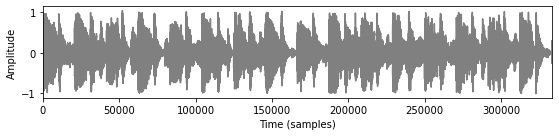

Processed Bassline

Fs = 44100, x.shape = (338395,), x.dtype = float64


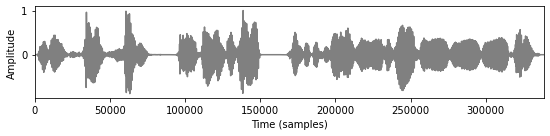

Unprocessed Bassline

Fs = 44100, x.shape = (333396,), x.dtype = float32


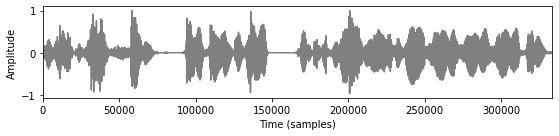

In [5]:
title = track_titles[31]

inspect_audio_outputs(title)

**Generate Spectrograms**

In [7]:
chorus, processed_bassline, _ = load_audio(title) # read the chorus and the bassline
fs = 44100

n_fft = 4096*8
win_length = 4096*2
hop_length = int(win_length/2) 

chorus_spectrogram = extract_dB_spectrogram(chorus, n_fft, win_length, hop_length) # create the spectrograms
bassline_spectrogram = extract_dB_spectrogram(processed_bassline, n_fft, win_length, hop_length)

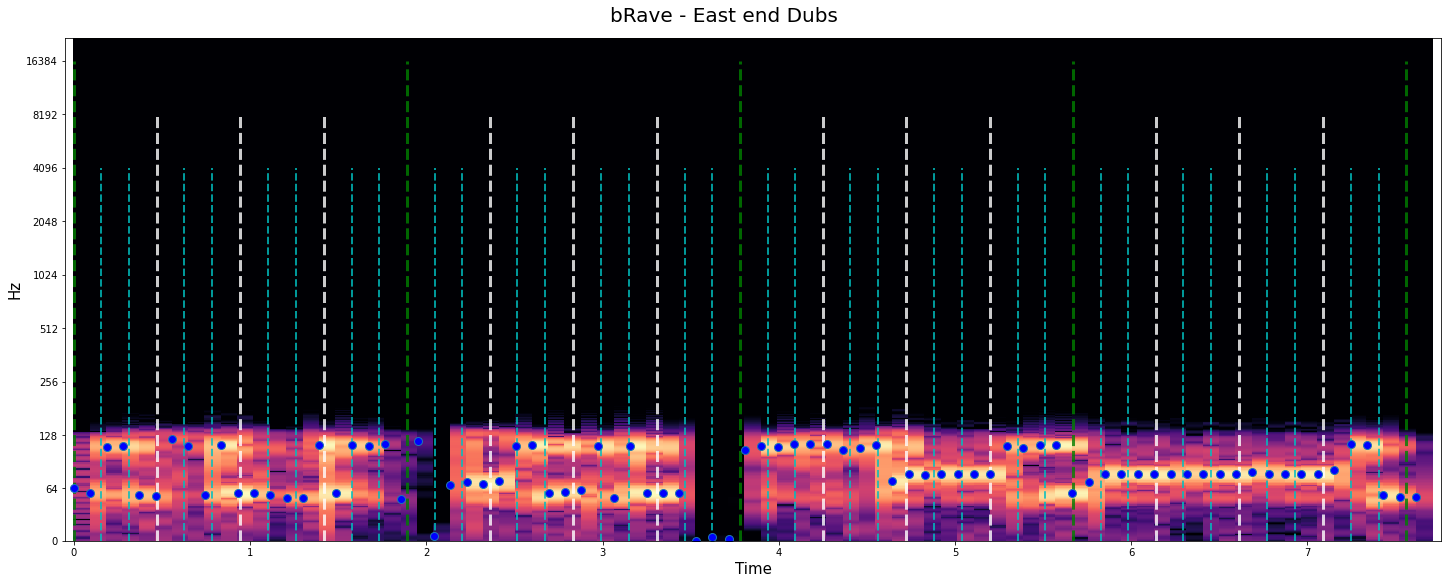

In [13]:
plot_spec(title, bassline_spectrogram, fs, hop_length, F0=True, save=True)

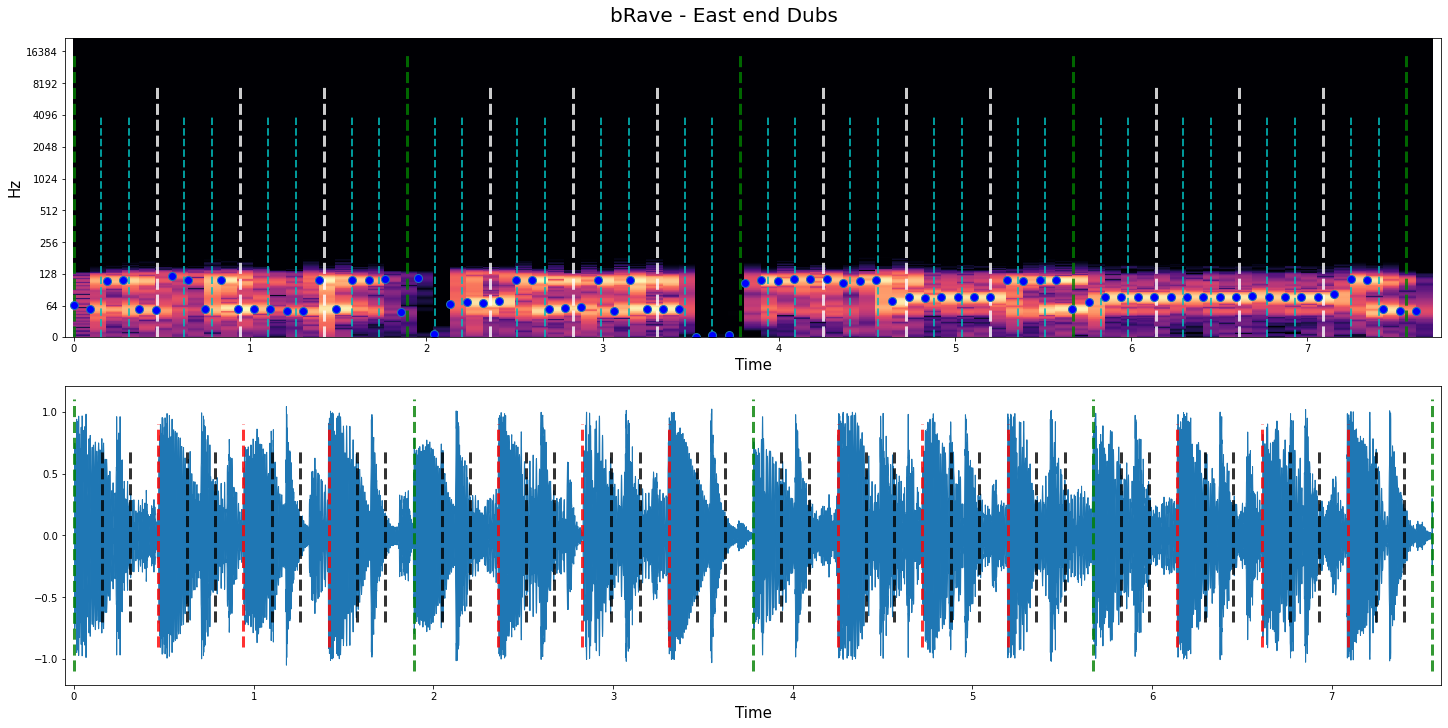

In [17]:
plot_wave_spec(title, chorus, bassline_spectrogram, fs, hop_length, F0=True, save=True)